In [1]:
from gtts import gTTS
import random, os
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Create Directory for Cache and Result

In [3]:
os.makedirs('samples', exist_ok=True)
os.makedirs('result', exist_ok=True)

# Define Input

In [4]:
string = '도움되는 강의'
lang = 'ko'
random_factor = 0.1
# normal_frame_rate = 44100

print(string)

도움되는 강의


# Process Audio

In [6]:
import librosa
import IPython

result_sound = None
for i, letter in enumerate(string):
    if letter == ' ': # fill empty sound
        # new_sound = letter_sound._spawn(b'\x00' * (normal_frame_rate // 3), overrides={'frame_rate': normal_frame_rate})
        new_sound = np.zeros(10000)
    else: # fill tts sound
        # create tts if sample sound not exist
        if not os.path.isfile('samples/%s.mp3' % letter):
            tts = gTTS(letter, lang=lang)
            tts.save('samples/%s.mp3' % letter)            

        letter_file_path = 'samples/%s.mp3' % letter
        x , sr = librosa.load(letter_file_path)

        step = 15 + random.random() * random_factor         
        new_sound = librosa.effects.pitch_shift(x,sr,step)    
    
    resample_sr = sr * 0.7 + 1000 * random.random()
    new_sound = librosa.resample(new_sound, sr, resample_sr)
    print(type(new_sound), type(resample_sr))
    print(new_sound.shape, resample_sr)
    # result_sound = new_sound if result_sound is None else result_sound + new_sound
    result_sound = new_sound if result_sound is None else np.append(result_sound,new_sound)    

result_sound
IPython.display.Audio(data=result_sound, rate=sr)      


<class 'numpy.ndarray'> <class 'float'>
(9472,) 15786.153380263086
<class 'numpy.ndarray'> <class 'float'>
(10193,) 16333.21539927998
<class 'numpy.ndarray'> <class 'float'>
(11298,) 16231.19758006858
<class 'numpy.ndarray'> <class 'float'>
(10792,) 15505.443894244849
<class 'numpy.ndarray'> <class 'float'>
(7110,) 15675.770623717117
<class 'numpy.ndarray'> <class 'float'>
(11369,) 16334.169705431046
<class 'numpy.ndarray'> <class 'float'>
(10488,) 16184.43452994934


In [7]:
example_audio = librosa.util.example_audio_file()
x, sr = librosa.load(example_audio, duration=5)
print('shape of x ==> ' + str(x.shape))
y, sr = librosa.load(example_audio, duration=5)
print('shape of y ==> ' + str(y.shape))
z = np.append(x,y)
print('shape of x+y = z ==> ' + str(z.shape))

shape of x ==> (110250,)
shape of y ==> (110250,)
shape of x+y = z ==> (220500,)


In [8]:
import soundfile as sf
sf.write('result/%s.wav' % string,result_sound, sr, 'PCM_24')

(70722,)


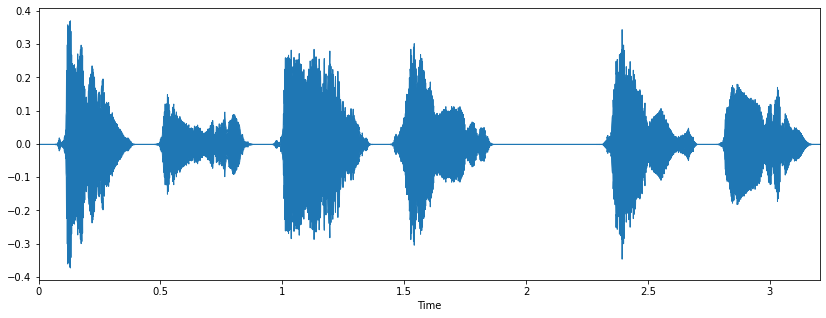

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

x = result_sound
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
print(x.shape)

(1025, 139)


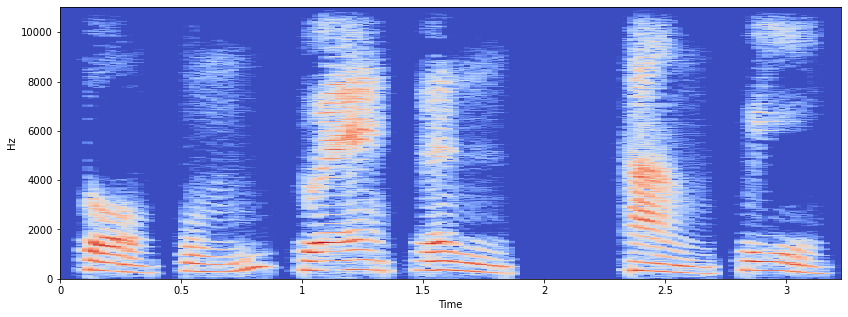

In [10]:
# Spectrogram
# A spectrogram is a visual representation of the spectrum of frequencies of sound 
# as they vary with time. It’s a representation of frequencies changing with respect to time for given music signals.'.stft' converts data into short term Fourier transform. STFT converts signal such that we can know the amplitude of given frequency at a given time. 
# Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal.

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
print(Xdb.shape)

In [11]:
# 1. Mel Frequency Cepstral Coefficients (MFCCs)
# The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features
# (usually about 10-20) which concisely describe the overall shape of a spectral envelope. 
# In MIR, it is often used to describe timbre.

mfccs = librosa.feature.mfcc(y=x, sr=sr)
print(mfccs.shape)

# In this case, mfcc computed 20 MFCCs over  frames.
# The very first MFCC, the 0th coefficient, does not convey information relevant to the overall shape of the spectrum. 
# It only conveys a constant offset, i.e. adding a constant value to the entire spectrum. 
# Therefore, many practitioners will discard the first MFCC when performing classification.

(20, 139)


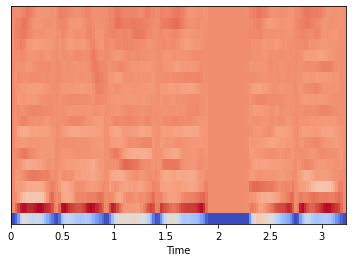

In [12]:
# Display the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

20

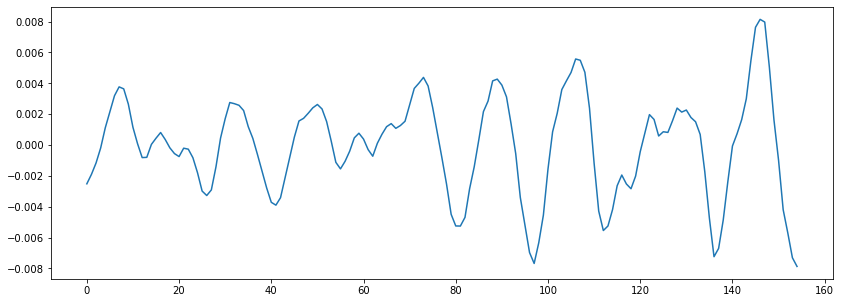

In [13]:
# 2. Zero Crossing Rate
# The zero crossing rate indicates the number of times that a signal crosses the horizontal axis.
# Let's Zoom in and make the wave simpler so that we can calculate Zero crossing rate manually and verify.

n0 = 2000
n1 = 2155
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
zero_crossings.shape
zero_crossings.sum()

In [14]:
# This gives the zero_crossings. We can verify this manually from the plot itself. 
# Now we can use the whole audio to go through this and deduce the zero crossings of the whole data.
zcrs = librosa.feature.zero_crossing_rate(x)
print(zcrs.shape)

(1, 139)


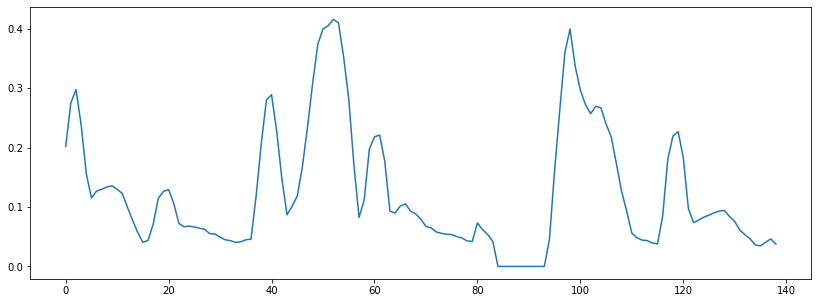

In [15]:
plt.figure(figsize=(14, 5))
plt.plot(zcrs[0])

3. Spectral Centroid
The spectral centroid (Wikipedia) indicates at which frequency the energy of a spectrum is centered upon. This is like a weighted mean:

fc=∑kS(k)f(k)∑kS(k)

where S(k) is the spectral magnitude at frequency bin k, f(k) is the frequency at bin k.

In [16]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

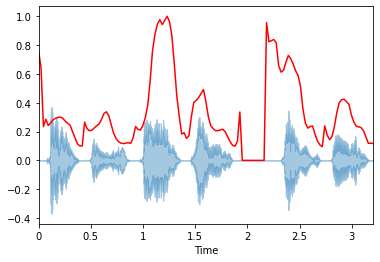

In [17]:
import sklearn
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

4.Spectral Bandwidth
librosa.feature.spectral_bandwidth computes the order-p

spectral bandwidth:

(∑kS(k)(f(k)−fc)p)1p

where S(k) is the spectral magnitude at frequency bin k, f(k) is the frequency at bin k, and fc is the spectral centroid. When p=2, this is like a weighted standard deviation.

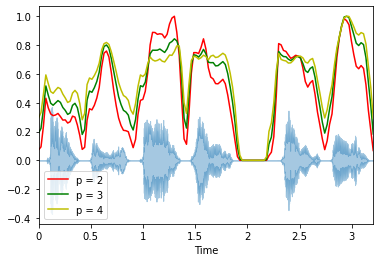

In [18]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

5. Spectral-roll off
Spectral rolloff is the frequency below which a specified percentage of the total spectral energy lies.

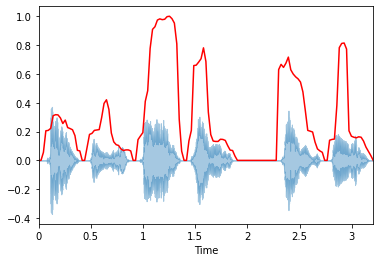

In [19]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

6. Chroma Feature
A chroma vector (Wikipedia) (FMP, p. 123) is a typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, ..., B}, is present in the signal.

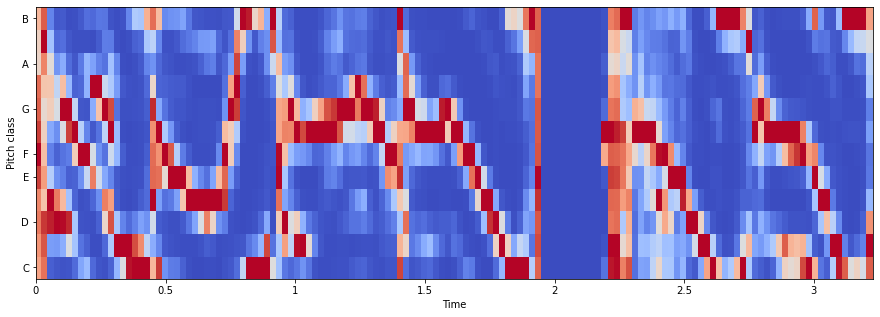

In [20]:
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=512)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

7. Pitches and Magnitudes
Pitch is a perceptual property of sounds that allows their ordering on a frequency-related scale, or more commonly, pitch is the quality that makes it possible to judge sounds as "higher" and "lower" in the sense associated with musical melodies.

In [21]:
pitches, magnitudes = librosa.piptrack(y=x, sr=sr)
print(pitches.shape)
print(pitches[50:65,20])
print(pitches[50:65,21])

(1025, 139)
[  0.           0.           0.           0.           0.
   0.         600.39274561   0.           0.           0.
   0.         653.75364033   0.           0.           0.        ]
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.         639.76727912
   0.           0.           0.           0.         685.07469372]


In [22]:
print(magnitudes[50:65,20])
print(magnitudes[50:65,21])

[0.         0.         0.         0.         0.         0.
 0.0286445  0.         0.         0.         0.         0.16912163
 0.         0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.97368892 0.         0.
 0.         0.         3.33972577]


Fin